# DBSCAN clustering to identify Crash Hotspots on Highways
This notebook uses DBSCAN to cluster Crashes on same Highways to a Hotspot
Part of the code is inspired by https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb

In [40]:
import geopandas as gpd
import pandas as pd
import time
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle

import matplotlib.pyplot as plt
#import geopandas as gpd
#from shapely.geometry import LineString, Point
#from geopy.distance import geodesic
#import os
import numpy as np

In [35]:
def convert_int(value):
    try: 
        return int(value)
    except Exception:
        return np.nan

In [4]:
unfallorte = gpd.read_file("Files/unfallorte_2022_HW_mapmatched_ref.shp")

### Data Preparation
convert functions for datarame to int, float data types

In [6]:
unfallorte['lat_lon'] = unfallorte.apply(lambda row: [row['YGCSWGS84'], row['XGCSWGS84']], axis=1)

In [31]:
unfallorte['lat'] = unfallorte['YGCSWGS84']
unfallorte['lon'] = unfallorte['XGCSWGS84']

### Aggregate unfallorte to a list of coordinates on same Highway section 

In [8]:
unfallorte_grouped = unfallorte.groupby('ref')['lat_lon'].agg(list).reset_index()

In [9]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
# define epsilon as 1.5 kilometers, converted to radians for use by haversine
epsilon = 3 / kms_per_radian

In [10]:
def dbscan_func(ref, coords):
    """
    Function to compute DBSCAN on an array of coordinates

    :param p1: higway constraint: ref id of Highway
    :param p2: array of coordinates
    """ 
    start_time = time.time()

    dbscan = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine')
    db = dbscan.fit(np.radians(coords))

    cluster_labels = db.labels_
    # get the number of clusters
    
    num_clusters = len(set(cluster_labels))

    # all done, print the outcome
    message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
    print(message.format(len(coords), num_clusters, 100*(1 - float(num_clusters) / len(coords)), time.time()-start_time))
    
    clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])
    centermost_points = clusters.map(get_centermost_point)
    
    # unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
    lats, lons = zip(*centermost_points)
    
    # from these lats/lons create a new df of one representative point for each cluster
    rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
    rep_points['cluster_size'] = clusters.apply(len)
    rep_points['ref'] = ref
    
    return rep_points

### Centermost Point
DBSCAN clusters may be non-convex. This technique just returns one representative point from each cluster. First get the lat,lon coordinates of the cluster's centroid (shapely represents the first coordinate in the tuple as x and the second as y, so lat is x and lon is y here). Then find the member of the cluster with the smallest great circle distance to the centroid.
See also https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb

In [22]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

### Apply DBSCAN Function
Apply DBSCAN function to dataframe. Determine cluster, its centermost points and cluster size

In [ ]:
columns = ['lon', 'lat', 'cluster_size', 'ref']
hw_rep_points = pd.DataFrame(columns=columns)

for idx, row in unfallorte_grouped.iterrows():
    result_df = dbscan_func(row["ref"], np.array(row["lat_lon"]))
    hw_rep_points = pd.concat([hw_rep_points, result_df], ignore_index=True)

### Merge
merge result to initial dataframe

In [32]:
unfallorte = pd.merge(unfallorte, hw_rep_points, on=['lon', 'lat'], how='right')

In [36]:
unfallorte["cluster_size"] = unfallorte["cluster_size"].apply(lambda x: convert_int(x))

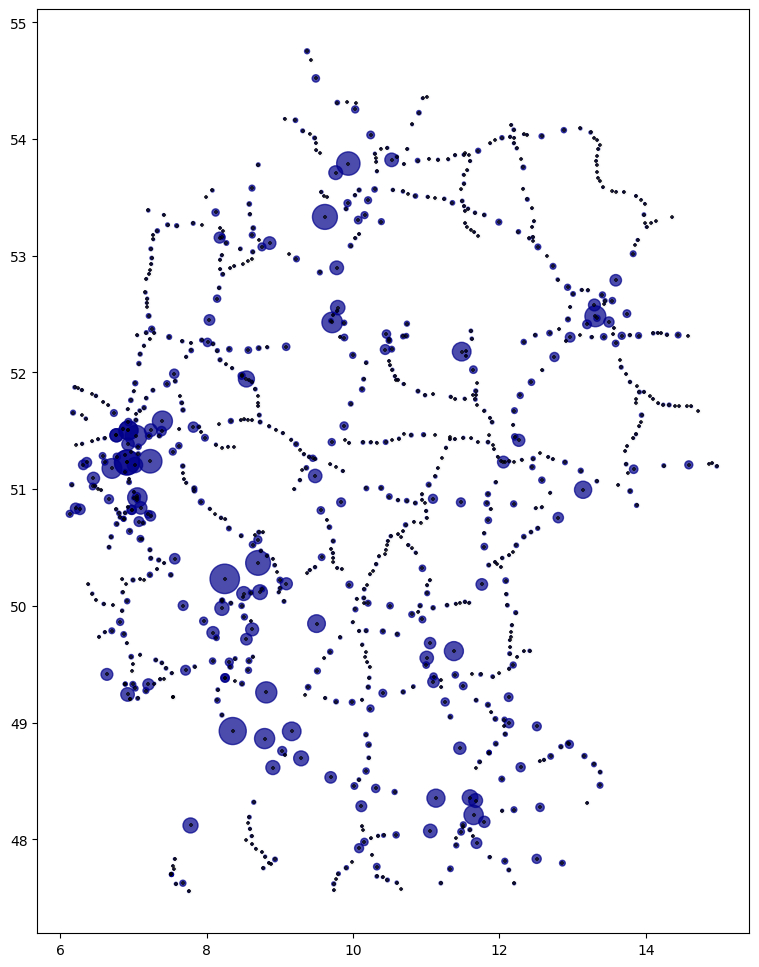

In [41]:
fig, ax = plt.subplots(figsize=(20, 12))

#ax.grid(which='major', color='k', linestyle='-', linewidth=0.5)
#ax.grid(which='minor', color='k', linestyle='-', linewidth=0.2)
#ax.minorticks_on()
unfallorte.plot(ax=ax, markersize=10, alpha = 0.05, color="gray")
#unfallorte3.plot(ax=ax, markersize=cluster_size, alpha = 0.9, color="darkblue")
plt.scatter(unfallorte['lon'], unfallorte['lat'], s=unfallorte['cluster_size'], alpha=0.7, color="darkblue")
plt.scatter(unfallorte['lon'], unfallorte['lat'], alpha=0.7, s=5, color="black", marker="+")

plt.show()

In [ ]:
unfallorte = unfallorte.drop("lat_lon", axis=1)
unfallorte.to_file("unfallorte_2022_HW_mapmatched_ref_DBSCAN_same_HW.shp")